# K-均值聚类

 K-均值聚类是一种最广泛使用的聚类算法。算法通过预先设定的类别数k及每个类别的初始质心对相似的数据点进行划分。并通过划分后的均值迭代优化获得最优的聚类结果。


其算法步骤如下（假定输入样本 $X_1,X_2,...,X_m$)：

（1）选择初始的k个类别中心$\mu_1,\mu_2,...,\mu_k$

（2）对每个样本$X_i$，将其标记为距离类别中心最近的类别，即：$label_i=\mathop{arg min} \limits_{1<j<k}{\|X_i-\mu_j\|}$

（3）将每个类别中心更新为隶属于该类别的所有样本的均值。即：$\mu_j=\frac {1} {|c_j|}\sum \limits_{i\in c_j} {X_i}$

（4）重复最后两步，直到类别中心变化小于某阈值。
    

根据算法思想与步骤，在此尝试自己编写一个类实现K-means算法。并且在普通K-means的基础上进行优化，K-means++算法可以优化初值的选择，而minibatch K-means主要运用于大批量数据时，提高算法效率。

最后，生成测试数据对算法进行比较和评价。另外，当类别数不确定时，可以使用手肘法帮助确定最优类别数。

## K-Means

In [7]:
# 自己写算法尝试实现k-means聚类
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class K_Means(object):
    
    # 初始化方法
    def __init__(self,n_classes,max_iter=100,tol=0.0001):

        self.n_classes=n_classes
        self.max_iter=max_iter
        self.tol=tol

        self.labels=None # 模型聚类标签
        self.center=None # 模型聚类中心
        self.sse=None # 模型SSE
        self.iter=None # 模型迭代次数
        self.sse_list=np.zeros(max_iter+1) #模型每次迭代的sse

    # 静态方法，计算两点之间的欧式距离
    @staticmethod
    def dist(x, y):
        return round(np.sqrt(np.sum(np.square(x - y))), 6)

    # 类方法，在一系列的点points中,寻找与给定点point的距离最近的点
    @classmethod
    def min_dist(cls, point, points):
        index = 0
        mindist = cls.dist(point, points[0])
        for i in range(len(points)):
            if mindist >= cls.dist(point, points[i]):
                index = i
                mindist = cls.dist(point, points[i])
        return index, mindist  # 距离点point最近的点为points[index]，这个最近距离为mindist

    # 类方法，计算组内平方和sse
    @classmethod
    def sse_calculate(cls, point, points):
        sse = 0
        for i in range(len(points)):
            sse += np.square(cls.dist(point, points[i]))
        return sse

    # 静态方法，生成随机颜色
    @staticmethod
    def randomcolor():
        colorArr = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F']
        color = ""
        for i in range(6):
            color += colorArr[np.random.randint(0, 15)]
        return "#" + color

    # 类方法，给出样本点及对应标签，已知聚类中心时绘制散点图的函数
    @classmethod
    def k_means_scatter(cls, center, data_X, labels):
        plt.figure()
        label_list = np.unique(labels)
        for i in label_list:
            plt.scatter(data_X[labels == i][:, 0], data_X[labels == i][:, 1], c=cls.randomcolor(), marker=".",
                        label='label' + str(i))
        plt.scatter(center[:, 0], center[:, 1], c=cls.randomcolor(), marker="x", label="cluster center")
        plt.legend(loc=2)

    # 实例方法，用于随机的生成初始的聚类中心
    def init_center(self,data_X):
        init_index = np.random.choice(len(data_X), size=self.n_classes, replace=False)  # 完全按照随机原则抽取
        return data_X[init_index]

    # 实例方法，根据具体的数据完成k-means聚类
    def fit(self, data_X, show_details=False):

        # 当前的迭代次数、SSE、标签及聚类中心
        now_iter = 0  # 迭代次数，初始值为0
        now_sse = float('inf') # 组内平方和，初始值为正无穷
        now_labels=-np.ones(len(data_X)) # 类别标签，初始值均为-1
        now_centers=self.init_center(data_X) # 聚类中心，初始值由init_center这个实例方法得到

        # 不断更新聚类中心及样本所属类别。
        # 直到迭代次数达到所给最大迭代次数，或者簇中心的变化/SSE的变化小于所给临界值。
        next_centers = self.init_center(data_X)
        self.sse_list[0]=float('inf')
        while now_iter<self.max_iter:
            # 更新迭代次数
            now_iter+=1
            # 更新聚类中心
            now_centers=copy.deepcopy(next_centers)
            # 更新每个样本的类别标签
            for i in range(len(data_X)):
                now_labels[i]=self.min_dist(data_X[i],now_centers)[0]  # 对于每个样本data_X[i]，将其标签labels[i]更新为距离类别中心最近的
            # 更新SSE（先记录旧的sse）
            old_sse=copy.deepcopy(now_sse)
            now_sse = 0
            for j in range(self.n_classes):
                now_sse += self.sse_calculate(now_centers[j], data_X[now_labels == j])  # 计算第now_iter次迭代完成后的SSE
            self.sse_list[now_iter]=now_sse
            # 根据样本现有标签计算出下次迭代的聚类中心，暂不更新
            for j in range(self.n_classes):
                next_centers[j]=np.mean(data_X[now_labels == j],axis=0)  # 新的聚类中心
            #聚类中心变化小于某个值时停止
            #if self.dist(now_centers,next_centers) <= self.tol:
            #   break
            # sse变化小于某个值时停止(两点之间距离的度量为欧氏距离时适用）
            if abs(old_sse-now_sse) <= self.tol:
                break

            # 详细呈现每次迭代后的结果
            if show_details is True:
                print('第',now_iter,'次迭代时')
                print('聚类中心是:\n',now_centers)
                print('样本的聚类标签是:',now_labels)
                print('SSE是:',now_sse)
                if len(data_X[0]) == 2:
                    self.k_means_scatter(now_centers, data_X, now_labels)
                    plt.title("iters =" + str(now_iter))
                print('=' * 50)

        # 总体更新迭代次数、SSE、标签及聚类中心
        self.iter=now_iter
        self.center=now_centers
        self.labels=now_labels
        self.sse=now_sse

    # 实例方法，呈现聚类结果
    def show_report(self,data_X):
        print('总迭代次数：',self.iter)
        print('聚类中心：\n', self.center)
        print('聚类标签：\n', self.labels)
        print('SSE：\n', self.sse)
        if len(data_X[0]) == 2:
            self.k_means_scatter(self.center, data_X, self.labels)
            plt.title("K-Means( iters =" + str(self.iter)+")")
        plt.figure()
        plt.plot(self.sse_list[:self.iter],'bo-')
        plt.xlabel("iter")
        plt.ylabel("SSE")
        plt.title("the SSE line")


## K-Means++

In [8]:
class K_MeansPlusPlus(K_Means):
    def __init__(self,n_classes,max_iter=100,tol=0.0001):
        super().__init__(n_classes,max_iter,tol)

    # 重写初始化聚类中心的实例方法。
    # k_means++方法可以优化初始聚类中心的选择，使各个聚类中心相互距离尽可能远
    def init_center(self, data_X):

        # 1、初始化一个空数组center，用于存储n_classes个聚类中心
        center = np.zeros([self.n_classes, len(data_X[0])])

        # 2、先从样本点中随机选择一个聚类中心，加入center中
        center[-1] = data_X[np.random.randint(len(data_X))]

        # 3、依次选择余下的n_classes-1个聚类中心
        # 每次都使用加权概率分布来随机来随机选择下一个中心点，距离之前已选定的的聚类中心的最近距离越远，权重越大
        for i in range(self.n_classes - 1):
            # （1）now_centers记录了center中已有的1+i个聚类中心
            now_centers = center[[-1] + list(range(i))]
            # （2）计算各个样本点与now_centers的最短距离。并依照这些距离生成下一次抽取该样本点的概率列表(距离值越大，被抽到的概率越大）。
            the_dist = np.zeros(len(data_X))
            for j in range(len(data_X)):
                the_dist[j] = self.min_dist(data_X[j], now_centers)[1]
            SUM = sum(the_dist)
            the_p = np.array(the_dist) / SUM
            # （3）根据已有概率列表，加权地抽取下一个样本点作为另一个聚类中心，加入center中
            center[i] = data_X[np.random.choice(a=len(data_X), p=the_p)]

        return center

## minibatch K-Means

In [9]:
class Minibatch_K_Means(K_Means):
    def __init__(self,n_classes,max_iter=100,tol=0.0001):
        super().__init__(n_classes,max_iter,tol)

    # 重写根据具体数据完成k-means聚类的方法。
    # 每次都利用部分样本来更新聚类中心
    def fit(self,data_X,batch_size,show_details=False):

        # 当前的迭代次数、SSE、标签及聚类中心
        now_iter = 0  # 迭代次数，初始值为0
        now_sse = float('inf') # 组内平方和，初始值为正无穷
        now_labels=-np.ones(len(data_X)) # 类别标签，初始值均为-1
        now_centers=self.init_center(data_X) # 聚类中心，初始值由init_center这个实例方法得到

        # 不断更新聚类中心及样本所属类别。
        # 直到迭代次数达到所给最大迭代次数，或者聚类中心的变化小于所给临界值
        next_centers = self.init_center(data_X)
        self.sse_list[0] = float('inf')
        while now_iter<self.max_iter:
            # 抽取小部分样本用于更新聚类中心
            minibatch_index=np.random.choice(len(data_X), size=batch_size, replace=False)
            minibatch_data=data_X[minibatch_index]
            # 更新迭代次数
            now_iter+=1
            # 更新聚类中心
            now_centers = copy.deepcopy(next_centers)
            # 更新抽取的样本的类别标签
            for i in minibatch_index:
                now_labels[i]=self.min_dist(data_X[i], now_centers)[0]
            # 根据更新的聚类中心和样本的标签，更新当前sse
            now_sse = 0
            for j in range(self.n_classes):
                now_sse += self.sse_calculate(now_centers[j], minibatch_data[now_labels[minibatch_index] == j])
            self.sse_list[now_iter]=now_sse
            # 根据抽取的样本现有标签计算下一次的聚类中心并记录下来,暂不更新
            for j in range(self.n_classes):
                next_centers[j]=np.mean(minibatch_data[now_labels[minibatch_index]==j],axis=0)
            # 聚类中心变化小于某个值时停止
            if self.dist(next_centers,now_centers) <= self.tol:
                break
            if show_details is True:
                print('第',now_iter,'次迭代时')
                print('聚类中心是:\n',now_centers)
                print('样本的聚类标签是:',now_labels)
                print('SSE是:',now_sse)
                print('=' * 50)
        # 更新迭代次数、聚类中心
        self.iter=now_iter
        self.center=now_centers
        # 求出所有样本的类别标签
        self.labels = np.zeros(len(data_X))
        for i in range(len(data_X)):
            self.labels[i] = self.min_dist(data_X[i], self.center)[0]
        # 根据求出的聚类中心和类别标签，更新所有样本的SSE
        final_SSE=0
        for j in range(self.n_classes):
            final_SSE += self.sse_calculate(self.center[j], data_X[self.labels == j])
        self.sse=final_SSE


## 测试

首先，生成测试数据。

In [10]:
# 生成测试数据
x1 = np.round(np.random.normal(4, 1, 3000), 2)
y1 = np.round(np.random.normal(4, 1, 3000), 2)

x2 = np.round(np.random.normal(-4, 1, 10000), 2)
y2 = np.round(np.random.normal(3, 1, 10000), 2)

x3 = np.round(np.random.normal(0, 1, 5000), 2)
y3 = np.round(np.random.normal(0, 1, 5000), 2)

x=np.hstack((x1,x2,x3))
y=np.hstack((y1,y2,y3))
test_data=np.array(list(zip(x, y)))

接下来，首先将原始数据可视化出来。

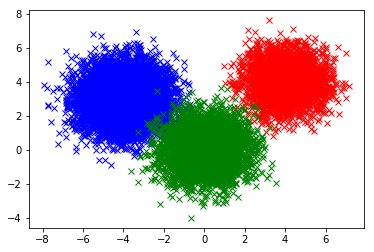

In [11]:
# 原始数据图像
plt.plot(x1,y1,'xr')
plt.plot(x2,y2,'xb')
plt.plot(x3,y3,'xg')

对于K-means、K-means++、minibatch K-means，依次构建模型对象，查看聚类结果，并比较聚类所用时间。

### K-means

第 1 次迭代时
聚类中心是:
 [[-4.51  2.71]
 [-0.27 -0.9 ]
 [-5.66  3.38]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 168156.782215
第 2 次迭代时
聚类中心是:
 [[-3.73547685  2.86611104]
 [ 1.51780195  1.4982158 ]
 [-5.28495441  3.73303951]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 89143.6057745
第 3 次迭代时
聚类中心是:
 [[-3.55468746  2.70956018]
 [ 1.62186085  1.53787423]
 [-5.03951488  3.59696068]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 87815.1381011
第 4 次迭代时
聚类中心是:
 [[-3.39554393  2.57370891]
 [ 1.68025029  1.55849692]
 [-4.86014686  3.52448191]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 86972.0306747
第 5 次迭代时
聚类中心是:
 [[-3.26271648  2.43096817]
 [ 1.73337512  1.58420456]
 [-4.72926543  3.48282109]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 86276.9674761
第 6 次迭代时
聚类中心是:
 [[-3.12486379  2.25910337]
 [ 1.79797301  1.61747001]
 [-4.61639524  3.45395431]]
样本的聚类标签是: [ 1.  1.  1. ...,  1.  1.  1.]
SSE是: 85482.8955054
第 7 次迭代时
聚类中心是:
 [[-2.96245316  2.05398322]
 [ 1.88163134  1.6637035 ]
 [-4.

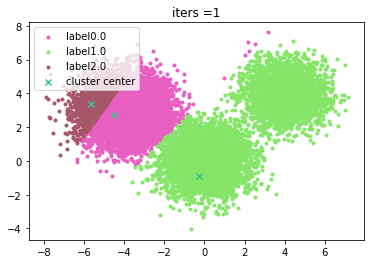

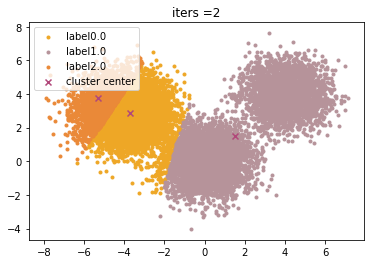

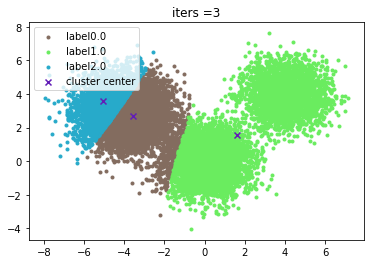

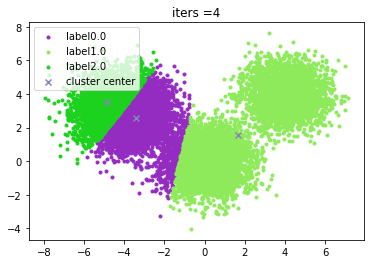

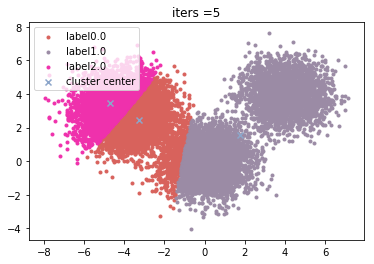

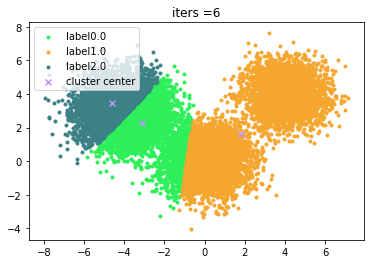

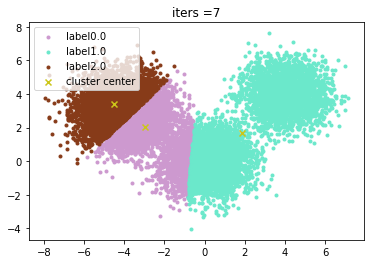

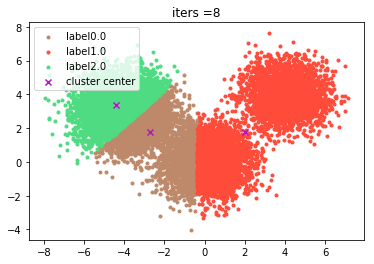

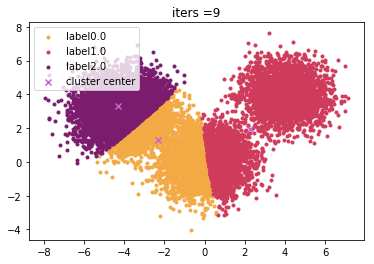

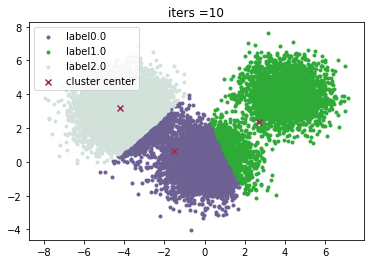

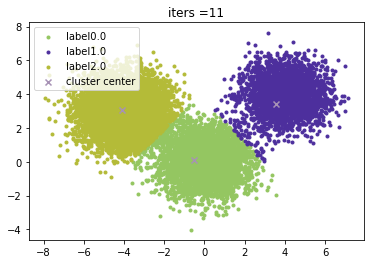

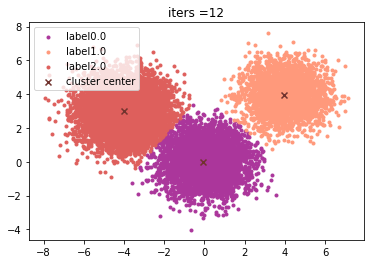

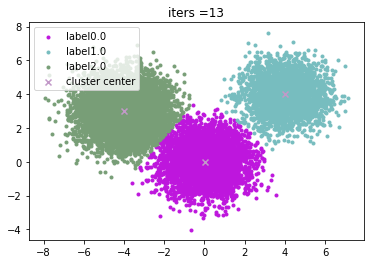

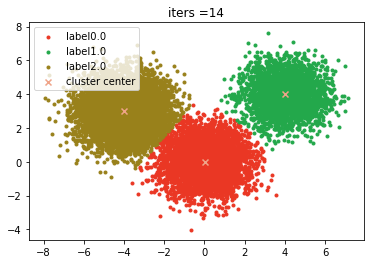

In [26]:
import time

start1=time.clock()
test1=K_Means(3,50,0.001)
test1.fit(test_data,show_details=True)
elapsed1 = (time.clock() - start1)


总迭代次数： 15
聚类中心：
 [[ 0.00993611  0.00913755]
 [ 4.01181335  3.98881103]
 [-3.99810521  3.00797495]]
聚类标签：
 [ 1.  1.  1. ...,  0.  0.  0.]
SSE：
 35253.4206655
K_Means time used: 15.972900625113311


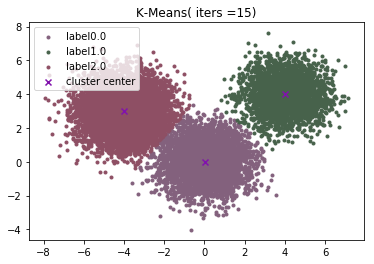

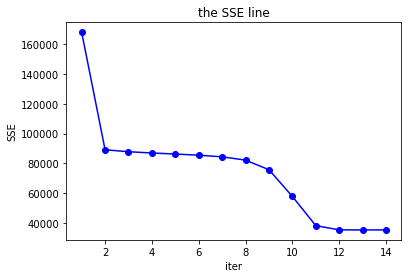

In [27]:
test1.show_report(test_data)
print('K_Means time used:',elapsed1)

### K-means++

第 1 次迭代时
聚类中心是:
 [[ 0.04 -2.86]
 [-3.52  5.04]
 [ 2.97  3.67]]
样本的聚类标签是: [ 2.  2.  2. ...,  2.  0.  0.]
SSE是: 116664.920745
第 2 次迭代时
聚类中心是:
 [[-0.11284641 -0.28811773]
 [-3.96880794  2.99926253]
 [ 3.33943113  3.4362523 ]]
样本的聚类标签是: [ 2.  2.  2. ...,  0.  0.  0.]
SSE是: 37904.0827451
第 3 次迭代时
聚类中心是:
 [[-0.00656199 -0.01893233]
 [-3.99475333  3.00689483]
 [ 3.96620319  3.94699446]]
样本的聚类标签是: [ 2.  2.  2. ...,  0.  0.  0.]
SSE是: 35269.8653487
第 4 次迭代时
聚类中心是:
 [[ 0.0091207   0.00672062]
 [-3.99747245  3.00798036]
 [ 4.00974784  3.98685468]]
样本的聚类标签是: [ 2.  2.  2. ...,  0.  0.  0.]
SSE是: 35253.4816965
第 5 次迭代时
聚类中心是:
 [[ 0.00993611  0.00913755]
 [-3.99810521  3.00797495]
 [ 4.01181335  3.98881103]]
样本的聚类标签是: [ 2.  2.  2. ...,  0.  0.  0.]
SSE是: 35253.4206655


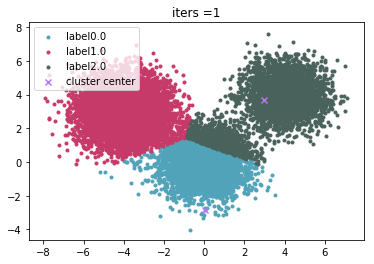

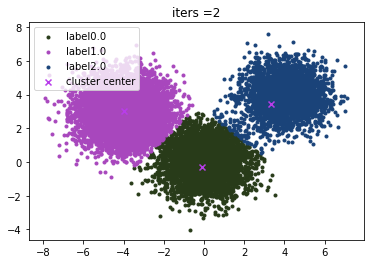

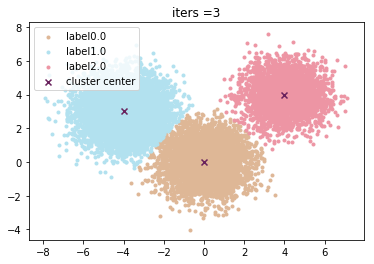

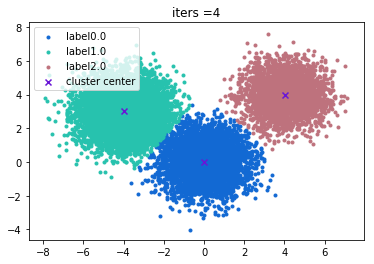

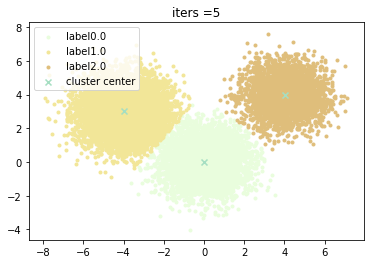

In [28]:
start2=time.clock()
test2=K_MeansPlusPlus(3,50,0.001)
test2.fit(test_data,show_details=True)
elapsed2 = (time.clock() - start2)

总迭代次数： 6
聚类中心：
 [[ 0.00993611  0.00913755]
 [-3.99810521  3.00797495]
 [ 4.01181335  3.98881103]]
聚类标签：
 [ 2.  2.  2. ...,  0.  0.  0.]
SSE：
 35253.4206655
K_MeansPlusPlus time used: 8.5920767963255


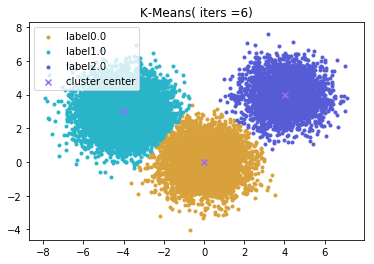

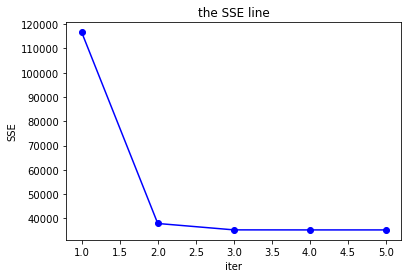

In [29]:
test2.show_report(test_data)
print('K_MeansPlusPlus time used:',elapsed2)

### minibatch K-means

In [30]:
start3=time.clock()
test3=Minibatch_K_Means(3,50,0.001)
test3.fit(test_data,batch_size=100,show_details=True)
elapsed3 = (time.clock() - start3)

第 1 次迭代时
聚类中心是:
 [[-0.44  0.28]
 [-6.1   4.84]
 [ 5.23  4.2 ]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 577.854603861
第 2 次迭代时
聚类中心是:
 [[-1.00439024  1.10902439]
 [-4.40111111  3.20955556]
 [ 4.30642857  3.86285714]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 276.590162916
第 3 次迭代时
聚类中心是:
 [[-0.1290625   0.3275    ]
 [-3.8852      3.1314    ]
 [ 3.92277778  3.65777778]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 189.579726788
第 4 次迭代时
聚类中心是:
 [[-0.08357143 -0.01607143]
 [-3.9154902   2.85215686]
 [ 3.83857143  4.02571429]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 167.728601965
第 5 次迭代时
聚类中心是:
 [[  2.66666667e-03  -5.30000000e-02]
 [ -3.82946429e+00   2.93160714e+00]
 [  4.06428571e+00   3.43214286e+00]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 174.486191287
第 6 次迭代时
聚类中心是:
 [[ -1.11111111e-01   1.48148148e-03]
 [ -4.05705882e+00   2.97254902e+00]
 [  3.82090909e+00   3.37954545e+00]]
样本的聚类标签是: [-1. -1. -1. ..., -1. -1. -1.]
SSE是: 185.397606103
第 7 次迭代时
聚类中心是:


总迭代次数： 50
聚类中心：
 [[ 0.00521739 -0.20347826]
 [-4.0787037   2.76074074]
 [ 3.99869565  4.26782609]]
聚类标签：
 [ 2.  2.  2. ...,  0.  0.  0.]
SSE：
 36379.8224993
Minibatch_K_Means time used: 1.3955285312596288


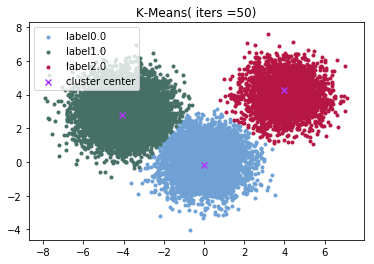

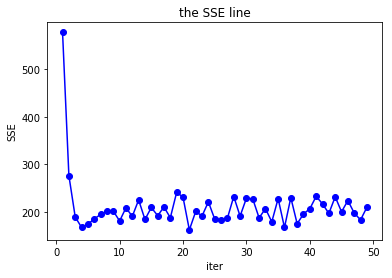

In [31]:
test3.show_report(test_data)
print('Minibatch_K_Means time used:',elapsed3)

可以看到，比起普通K-means算法，K-means++算法选择了更加分散的初始聚类中心，聚类过程更加准确、迅速、简洁。而minibatch K-means每次只选用部分样本进行迭代计算，明显优化了聚类时间，最终的聚类效果（以SSE衡量）与采用全部样本计算进行迭代普通K-means相差无几。

##  手肘法选择最优k值

当聚类的类别数无法确定时，可以采用手肘法判断最优k值。手肘法的核心指标是SSE。

手肘法的核心思想是：随着聚类数k的增大，样本划分会更加精细，每个簇的聚合程度会逐渐提高，那么误差平方和SSE自然会逐渐变小。并且，当k小于真实聚类数时，由于k的增大会大幅增加每个簇的聚合程度，故SSE的下降幅度会很大，而当k到达真实聚类数时，再增加k所得到的聚合程度回报会迅速变小，所以SSE的下降幅度会骤减，然后随着k值的继续增大而趋于平缓，也就是说SSE和k的关系图是一个手肘的形状，而这个肘部对应的k值就是数据的真实聚类数。


In [32]:
def best_k(data_X,max_iter,tol,max_k=10):
    SSE=[]
    for k in range(1,max_k):
        model=K_Means(k,max_iter,tol)
        model.fit(data_X)
        SSE.append(model.sse)
    plt.figure()
    plt.plot(range(1,max_k),SSE[:], 'bo-')
    plt.xlabel("k")
    plt.ylabel("SSE")
    plt.title("the SSE")
    return

利用鸢尾花数据进行测试，绘制SSE随类别数变化的折线图，手肘法判断最优k值

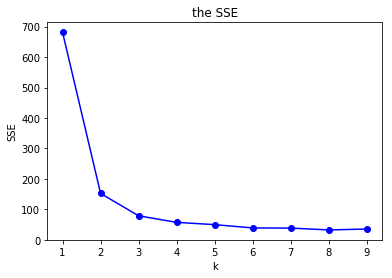

In [33]:
# 利用鸢尾花数据测试手肘法判断最优类别数
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,:]
best_k(X,100,0.0001)  # 肘部对应的k为3